In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.legend_handler import HandlerBase

from sklearn.decomposition import PCA
from scipy.interpolate import interp1d

import os
import re

import h5py
from tqdm import tqdm

from utils import *
import mdaux
colors = mdaux.getValToColorMap([-1, 0, 1, 2, 3, 4])

In [241]:
# # this will load the data from the hdf5 file and format it as a pandas dataframe
# # the hdf5 files need to be in the current directory (same as the notebook)
# # ONLY RUN THIS CELL ONCE TO GET THE CSV FILES

# for dirname, _, filenames in os.walk('./'):
#     for filename in filenames:
#         path = os.path.join(dirname, filename)
#         if '.hdf5' in filename:
#             print(f'loading {path}')
#             df = load_and_format_data_as_df(path)
#             df.to_csv(f"./{filename.replace('.hdf5', '.csv')}", index=False)
#             print(f'saved under {filename.replace(".hdf5", ".csv")}')

In [242]:
df_A = pd.read_csv('A_nodes.csv', index_col=0)
df_B = pd.read_csv('B_nodes.csv', index_col=0)
df_C = pd.read_csv('C_nodes.csv', index_col=0)

In [243]:
# data encompasses "flock formation, circling, and landing" over a 30 minute period
# ~1800 chimney swift birds
# there are regions reported where the birds are highly correlated - when flying - and less correlated - when landing - as the intention of the study

In [244]:
# range of time in minutes
(df_A.time.max() - df_A.time.min()) / 60, (df_B.time.max() - df_B.time.min()) / 60, (df_C.time.max() - df_C.time.min()) / 60

(8.505727950172396, 9.431653876098322, 8.19263708152597)

In [245]:
# individual time ranges for tracks
# A
df_A.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    24966.000000
mean         7.405351
std          6.848828
min          0.934268
25%          2.535869
50%          5.071738
75%         10.010010
max        100.066733
dtype: float64

In [246]:
# individual time ranges for tracks
# B
df_B.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    78498.000000
mean         6.520097
std          5.619826
min          0.934268
25%          2.435769
50%          4.671338
75%          8.842176
max         59.092426
dtype: float64

In [247]:
# individual time ranges for tracks
# C
df_C.groupby('tid').apply(lambda x: x.time.max() - x.time.min()).describe()

count    39403.000000
mean         4.478242
std          3.859843
min          0.934268
25%          1.968635
50%          3.169837
75%          5.472139
max         42.442442
dtype: float64

In [248]:
# velocity order parameter
vel_order_A = get_velocity_order_parameter(df_A)
vel_order_B = get_velocity_order_parameter(df_B)
vel_order_C = get_velocity_order_parameter(df_C)

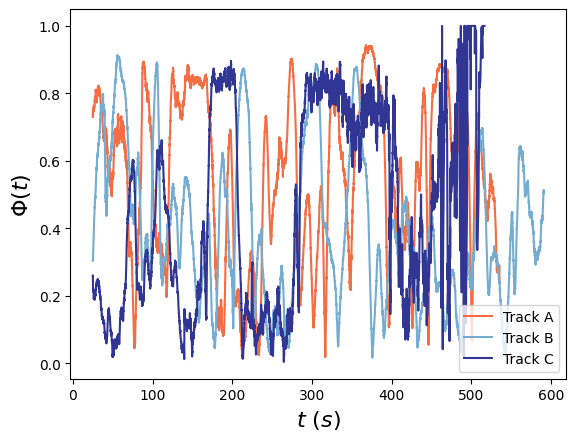

In [249]:
plt.plot(np.sort(df_A.time.unique()), vel_order_A, label='Track A', color=colors[0])
plt.plot(np.sort(df_B.time.unique()), vel_order_B, label='Track B', color=colors[3])
plt.plot(np.sort(df_C.time.unique()), vel_order_C, label='Track C', color=colors[4])
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel('$\Phi(t)$', fontsize=16)
plt.savefig('velocity_order_parameter.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
vars_A = get_variance_ratios(df_A)
vars_B = get_variance_ratios(df_B)
vars_C = get_variance_ratios(df_C)

100%|██████████| 4881/4881 [00:11<00:00, 423.84it/s]


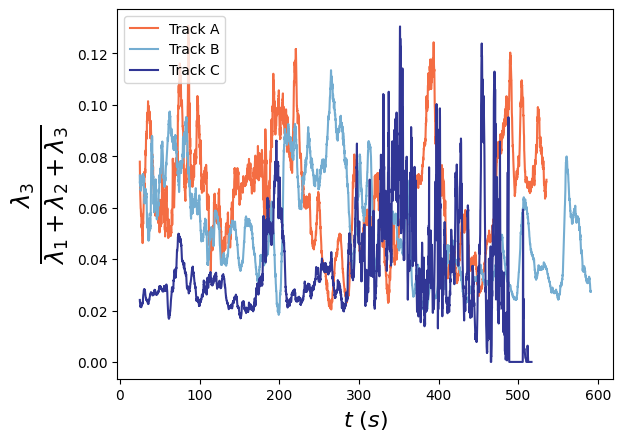

In [12]:
plt.plot(np.linspace(df_A.time.min(), df_A.time.max(), len(vars_A)), vars_A[:, 2], label='Track A', color=colors[0])
plt.plot(np.linspace(df_B.time.min(), df_B.time.max(), len(vars_B)), vars_B[:, 2], label='Track B', color=colors[3])
plt.plot(np.linspace(df_C.time.min(), df_C.time.max(), len(vars_C)), vars_C[:, 2], label='Track C', color=colors[4])
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.savefig('variance_ratios.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# get density
densities_A = get_number_densities(df_A)
densities_B = get_number_densities(df_B)
densities_C = get_number_densities(df_C)

 95%|█████████▌| 4639/4881 [00:11<00:00, 507.31it/s]/Users/mmccraw/dev/yale/courses/integrated-workshop/project/code/data/utils.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  densities.append(sub_df.tid.nunique() / volume)
100%|██████████| 4881/4881 [00:11<00:00, 411.36it/s]


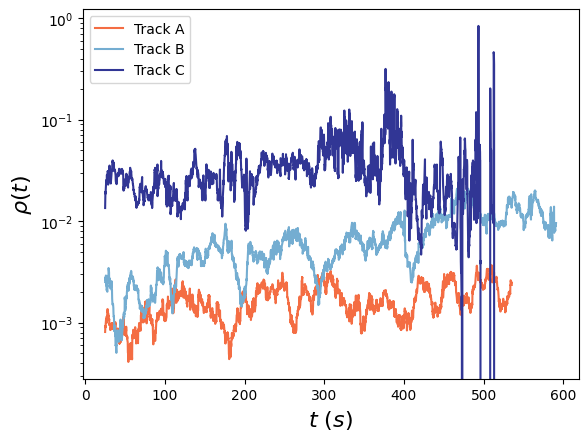

In [14]:
plt.plot(np.linspace(df_A.time.min(), df_A.time.max(), len(densities_A)), densities_A, label='Track A', color=colors[0])
plt.plot(np.linspace(df_B.time.min(), df_B.time.max(), len(densities_B)), densities_B, label='Track B', color=colors[3])
plt.plot(np.linspace(df_C.time.min(), df_C.time.max(), len(densities_C[densities_C < 1e6])), densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.yscale('log')
plt.legend()
plt.xlabel('$t$ ($s$)', fontsize=16)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('number_density.png', dpi=300, bbox_inches='tight')

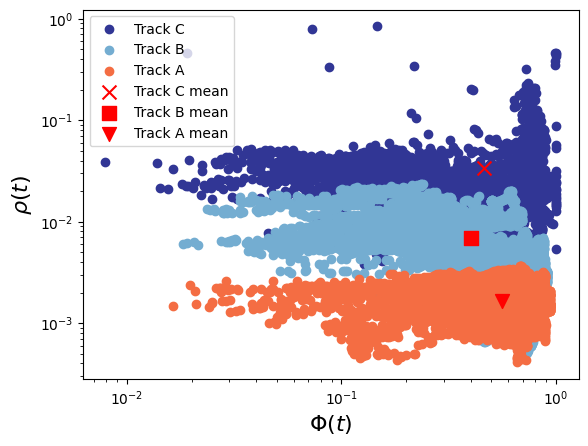

In [15]:
# correlation between velocity order parameter and density
plt.scatter(downsample_A2B(vel_order_C, densities_C[densities_C < 1e6]), densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.scatter(downsample_A2B(vel_order_B, densities_B), densities_B, label='Track B', color=colors[3])
plt.scatter(downsample_A2B(vel_order_A, densities_A), densities_A, label='Track A', color=colors[0])
plt.scatter(np.mean(downsample_A2B(vel_order_C, densities_C[densities_C < 1e6])), np.mean(densities_C[densities_C < 1e6]), label='Track C mean', color='r', marker='x', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_B, densities_B)), np.mean(densities_B), label='Track B mean', color='r', marker='s', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_A, densities_A)), np.mean(densities_A), label='Track A mean', color='r', marker='v', s=100)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('$\Phi(t)$', fontsize=16)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('velocity_order_parameter_vs_density.png', dpi=300, bbox_inches='tight')

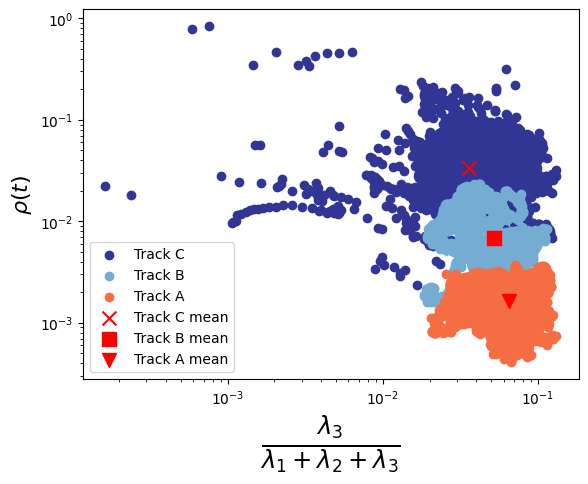

In [16]:
# correlation between velocity order parameter and density
plt.scatter(vars_C[:, 2][densities_C < 1e6], densities_C[densities_C < 1e6], label='Track C', color=colors[4])
plt.scatter(vars_B[:, 2], densities_B, label='Track B', color=colors[3])
plt.scatter(vars_A[:, 2], densities_A, label='Track A', color=colors[0])
plt.scatter(np.mean(vars_C[:, 2][densities_C < 1e6]), np.mean(densities_C[densities_C < 1e6]), label='Track C mean', color='r', marker='x', s=100)
plt.scatter(np.mean(vars_B[:, 2]), np.mean(densities_B), label='Track B mean', color='r', marker='s', s=100)
plt.scatter(np.mean(vars_A[:, 2]), np.mean(densities_A), label='Track A mean', color='r', marker='v', s=100)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.savefig('variance_ratios_vs_density.png', dpi=300, bbox_inches='tight')

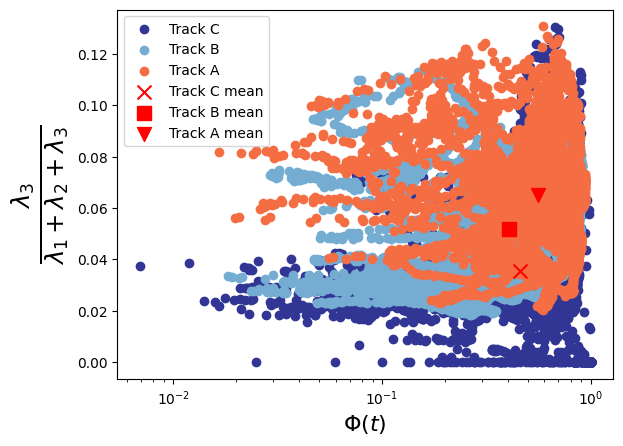

In [17]:
plt.scatter(downsample_A2B(vel_order_C, vars_C[:, 2]), vars_C[:, 2], label='Track C', color=colors[4])
plt.scatter(downsample_A2B(vel_order_B, vars_B[:, 2]), vars_B[:, 2], label='Track B', color=colors[3])
plt.scatter(downsample_A2B(vel_order_A, vars_A[:, 2]), vars_A[:, 2], label='Track A', color=colors[0])
plt.scatter(np.mean(downsample_A2B(vel_order_C, vars_C[:, 2])), np.mean(vars_C[:, 2]), label='Track C mean', color='r', marker='x', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_B, vars_B[:, 2])), np.mean(vars_B[:, 2]), label='Track B mean', color='r', marker='s', s=100)
plt.scatter(np.mean(downsample_A2B(vel_order_A, vars_A[:, 2])), np.mean(vars_A[:, 2]), label='Track A mean', color='r', marker='v', s=100)
plt.xscale('log')
plt.legend()
plt.xlabel('$\Phi(t)$', fontsize=16)
plt.ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.savefig('velocity_order_parameter_vs_variance_ratios.png', dpi=300, bbox_inches='tight')

100%|██████████| 1373/1373 [00:03<00:00, 452.53it/s]


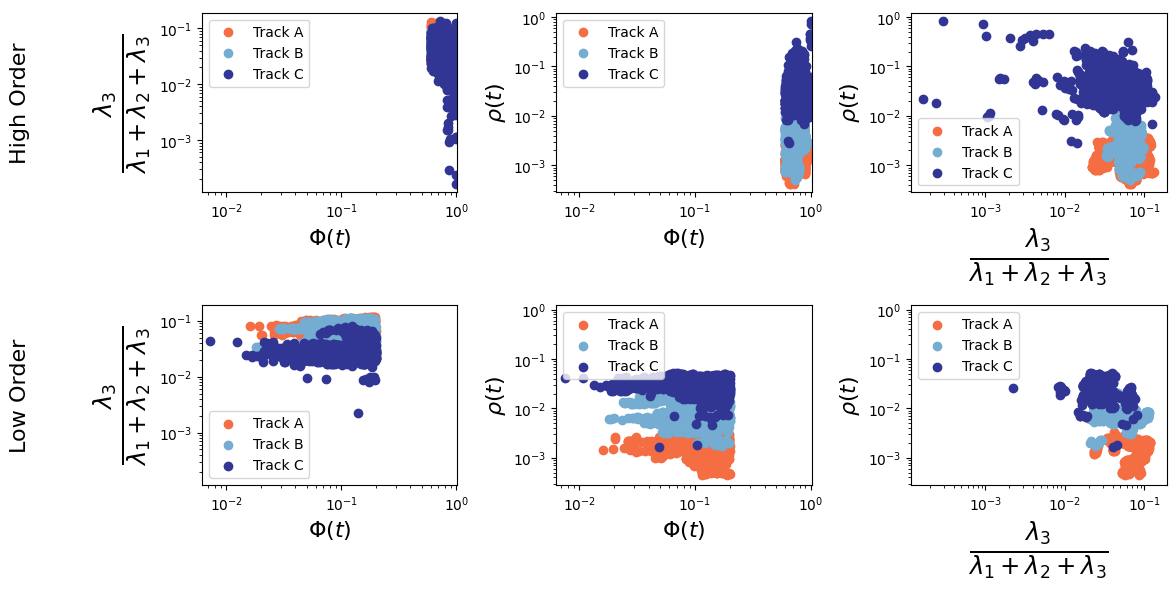

In [18]:
# is there common behavior in the high ordered regime and low ordered regime?
phi_high = 0.6
phi_low = 0.2

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

labels = ['Track A', 'Track B', 'Track C']
dfs = [df_A, df_B, df_C]
vel_orders = [vel_order_A, vel_order_B, vel_order_C]
cs = [colors[0], colors[3], colors[4]]

for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    df_sub = df[df.time.isin(vel_order[vel_order > phi_high].index.values)].copy()
    # vel = get_velocity_order_parameter(df_sub)
    vel = vel_order[vel_order > phi_high]
    var = get_variance_ratios(df_sub)
    dens = get_number_densities(df_sub)
    if df_sub.shape[0] > 0:
        axs[0, 0].scatter(downsample_A2B(vel, var[:, 2][var[:, 2] > 1e-9]), var[:, 2][var[:, 2] > 1e-9], label=label, color=color)
        axs[0, 1].scatter(downsample_A2B(vel, dens[dens < 1e6]), dens[dens < 1e6], label=label, color=color)
        axs[0, 2].scatter(var[:, 2][dens < 1e6], dens[dens < 1e6], label=label, color=color)

for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    df_sub = df[df.time.isin(vel_order[vel_order < phi_low].index.values)].copy()
    # vel = get_velocity_order_parameter(df_sub)
    vel = vel_order[vel_order < phi_low]
    var = get_variance_ratios(df_sub)
    dens = get_number_densities(df_sub)
    if df_sub.shape[0] > 0:
        axs[1, 0].scatter(downsample_A2B(vel, var[:, 2][var[:, 2] > 1e-9]), var[:, 2][var[:, 2] > 1e-9], label=label, color=color)
        axs[1, 1].scatter(downsample_A2B(vel, dens[dens < 1e6]), dens[dens < 1e6], label=label, color=color)
        axs[1, 2].scatter(var[:, 2][dens < 1e6], dens[dens < 1e6], label=label, color=color)

for i, _ in enumerate(axs):
    axs[i, 0].set_xlabel('$\Phi(t)$', fontsize=16)
    axs[i, 0].set_ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
    axs[i, 1].set_xlabel('$\Phi(t)$', fontsize=16)
    axs[i, 1].set_ylabel(r'$\rho(t)$', fontsize=16)
    axs[i, 2].set_xlabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
    axs[i, 2].set_ylabel(r'$\rho(t)$', fontsize=16)
    for j, ax in enumerate(_):
        ax.legend()
        # if j != 0:
        ax.set_yscale('log')
        ax.set_xscale('log')

for i, ax in enumerate(axs[0]):
    x_low = np.inf
    x_high = -np.inf
    y_low = np.inf
    y_high = -np.inf
    for j, _ in enumerate(axs):
        x_low = min(x_low, axs[j, i].get_xlim()[0])
        x_high = max(x_high, axs[j, i].get_xlim()[1])
        y_low = min(y_low, axs[j, i].get_ylim()[0])
        y_high = max(y_high, axs[j, i].get_ylim()[1])
    for j, _ in enumerate(axs):
        axs[j, i].set_xlim(x_low, x_high)
        axs[j, i].set_ylim(y_low, y_high)

label_offset = 0.75
axs[0, 0].text(-label_offset, 0.5, 'High Order', va='center', ha='left', rotation='vertical', transform=axs[0, 0].transAxes, fontsize=16)
axs[1, 0].text(-label_offset, 0.5, 'Low Order', va='center', ha='left', rotation='vertical', transform=axs[1, 0].transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('high_vs_low_order_correlations.png', dpi=300, bbox_inches='tight')

100%|██████████| 1373/1373 [00:02<00:00, 483.01it/s]


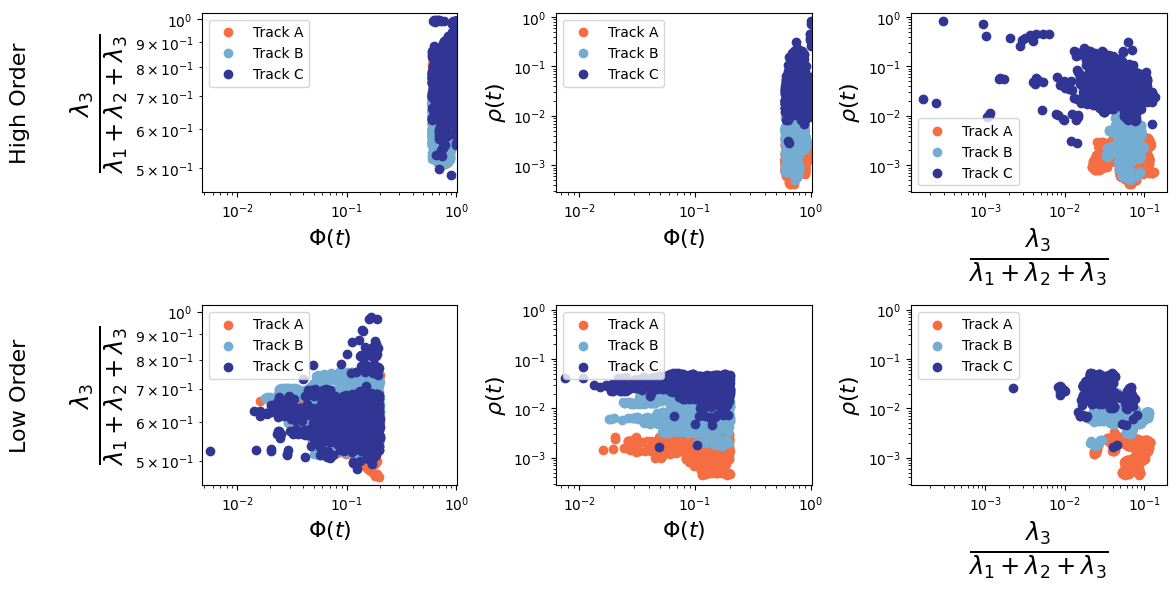

In [250]:
# is there common behavior in the high ordered regime and low ordered regime?
phi_high = 0.6
phi_low = 0.2

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

labels = ['Track A', 'Track B', 'Track C']
dfs = [df_A, df_B, df_C]
vel_orders = [vel_order_A, vel_order_B, vel_order_C]
cs = [colors[0], colors[3], colors[4]]

for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    df_sub = df[df.time.isin(vel_order[vel_order > phi_high].index.values)].copy()
    # vel = get_velocity_order_parameter(df_sub)
    vel = vel_order[vel_order > phi_high]
    var = get_variance_ratios(df_sub)
    dens = get_number_densities(df_sub)
    if df_sub.shape[0] > 0:
        axs[0, 0].scatter(downsample_A2B(vel, var[:, 0][var[:, 0] > 1e-9]), var[:, 0][var[:, 0] > 1e-9], label=label, color=color)
        axs[0, 1].scatter(downsample_A2B(vel, dens[dens < 1e6]), dens[dens < 1e6], label=label, color=color)
        axs[0, 2].scatter(var[:, 2][dens < 1e6], dens[dens < 1e6], label=label, color=color)

for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    df_sub = df[df.time.isin(vel_order[vel_order < phi_low].index.values)].copy()
    # vel = get_velocity_order_parameter(df_sub)
    vel = vel_order[vel_order < phi_low]
    var = get_variance_ratios(df_sub)
    dens = get_number_densities(df_sub)
    if df_sub.shape[0] > 0:
        axs[1, 0].scatter(downsample_A2B(vel, var[:, 0][var[:, 0] > 1e-9]), var[:, 0][var[:, 0] > 1e-9], label=label, color=color)
        axs[1, 1].scatter(downsample_A2B(vel, dens[dens < 1e6]), dens[dens < 1e6], label=label, color=color)
        axs[1, 2].scatter(var[:, 2][dens < 1e6], dens[dens < 1e6], label=label, color=color)

for i, _ in enumerate(axs):
    axs[i, 0].set_xlabel('$\Phi(t)$', fontsize=16)
    axs[i, 0].set_ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
    axs[i, 1].set_xlabel('$\Phi(t)$', fontsize=16)
    axs[i, 1].set_ylabel(r'$\rho(t)$', fontsize=16)
    axs[i, 2].set_xlabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
    axs[i, 2].set_ylabel(r'$\rho(t)$', fontsize=16)
    for j, ax in enumerate(_):
        ax.legend()
        # if j != 0:
        ax.set_yscale('log')
        ax.set_xscale('log')

for i, ax in enumerate(axs[0]):
    x_low = np.inf
    x_high = -np.inf
    y_low = np.inf
    y_high = -np.inf
    for j, _ in enumerate(axs):
        x_low = min(x_low, axs[j, i].get_xlim()[0])
        x_high = max(x_high, axs[j, i].get_xlim()[1])
        y_low = min(y_low, axs[j, i].get_ylim()[0])
        y_high = max(y_high, axs[j, i].get_ylim()[1])
    for j, _ in enumerate(axs):
        axs[j, i].set_xlim(x_low, x_high)
        axs[j, i].set_ylim(y_low, y_high)

label_offset = 0.75
axs[0, 0].text(-label_offset, 0.5, 'High Order', va='center', ha='left', rotation='vertical', transform=axs[0, 0].transAxes, fontsize=16)
axs[1, 0].text(-label_offset, 0.5, 'Low Order', va='center', ha='left', rotation='vertical', transform=axs[1, 0].transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('high_vs_low_order_correlations_with_first_dim_variance.png', dpi=300, bbox_inches='tight')

100%|██████████| 2484/2484 [00:03<00:00, 748.44it/s]


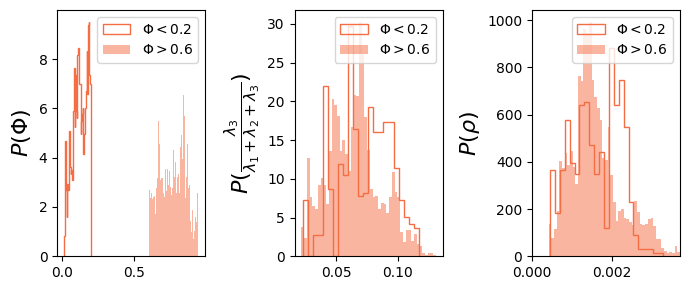

100%|██████████| 1183/1183 [00:02<00:00, 589.16it/s]


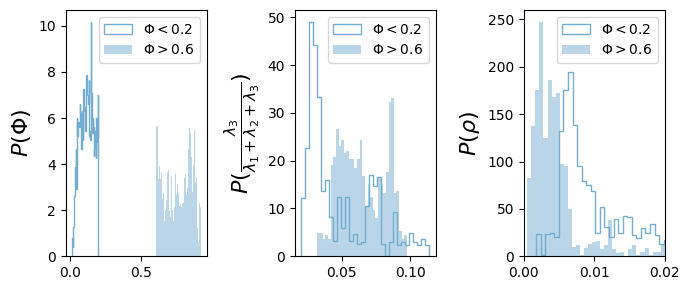

100%|██████████| 1901/1901 [00:00<00:00, 1916.59it/s]


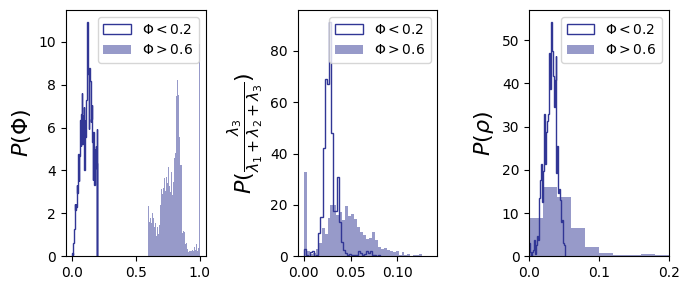

In [23]:
# vel_order_A[vel_order_A > phi_high].time
labels = ['Track A', 'Track B', 'Track C']
dfs = [df_A, df_B, df_C]
vel_orders = [vel_order_A, vel_order_B, vel_order_C]
cs = [colors[0], colors[3], colors[4]]

for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    fig, ax = plt.subplots(1, 3, figsize=(7, 3))
    for condition, cond_label in zip([vel_order > phi_high, vel_order < phi_low][::-1], [r'$\Phi>0.6$', r'$\Phi<0.2$'][::-1]):
        df_sub = df[df.time.isin(vel_order[condition].index.values)].copy()
        # vel = get_velocity_order_parameter(df_sub)
        vel = vel_order[condition]
        var = get_variance_ratios(df_sub)
        dens = get_number_densities(df_sub)
        plot_labels = [r'$P(\Phi)$', r'$P(\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3})$', r'$P(\rho)$']
        if vel.size > 0:
            for i, thing_to_plot in enumerate([vel, var[:, 2], dens[dens < 1e6]]):
                ax[i].set_ylabel(plot_labels[i], fontsize=16)
                if i == 2:
                    xmax = min(max(thing_to_plot), 0.2)
                    ax[i].set_xlim(0, xmax)
                if cond_label == r'$\Phi>0.6$':
                    ax[i].hist(thing_to_plot, bins=int(np.sqrt(thing_to_plot.size)), color=color, density=True, label=cond_label, alpha=0.5)
                else:
                    ax[i].hist(thing_to_plot, bins=int(np.sqrt(thing_to_plot.size)), color=color, density=True, histtype='step', label=cond_label)
    for _ in ax:
        _.legend()
    plt.tight_layout()
    plt.savefig(f'high_vs_low_order_correlations_PDF_{label}.png', dpi=300, bbox_inches='tight')
    plt.show()

100%|██████████| 2484/2484 [00:04<00:00, 572.64it/s]


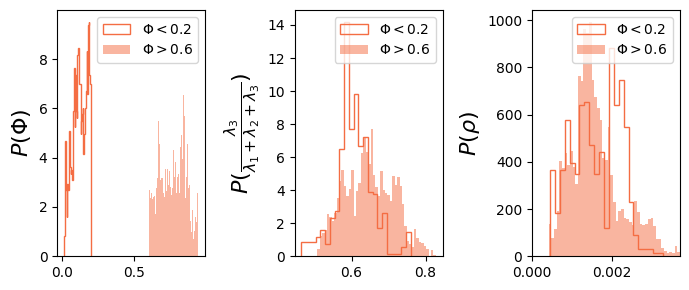

100%|██████████| 1183/1183 [00:02<00:00, 537.06it/s]


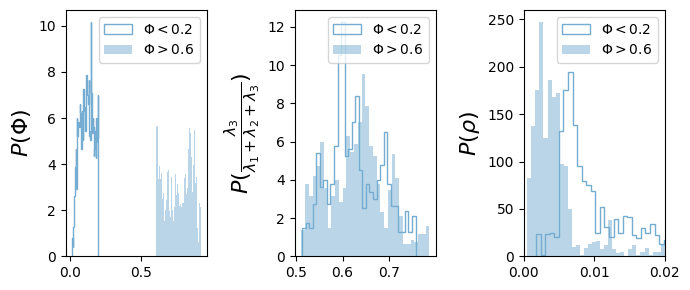

100%|██████████| 1901/1901 [00:01<00:00, 1078.39it/s]


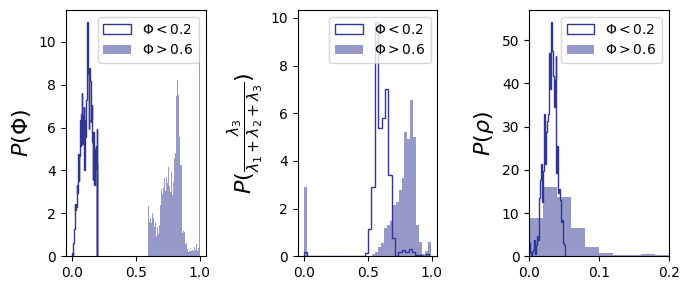

In [251]:
# vel_order_A[vel_order_A > phi_high].time
labels = ['Track A', 'Track B', 'Track C']
dfs = [df_A, df_B, df_C]
vel_orders = [vel_order_A, vel_order_B, vel_order_C]
cs = [colors[0], colors[3], colors[4]]

for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    fig, ax = plt.subplots(1, 3, figsize=(7, 3))
    for condition, cond_label in zip([vel_order > phi_high, vel_order < phi_low][::-1], [r'$\Phi>0.6$', r'$\Phi<0.2$'][::-1]):
        df_sub = df[df.time.isin(vel_order[condition].index.values)].copy()
        # vel = get_velocity_order_parameter(df_sub)
        vel = vel_order[condition]
        var = get_variance_ratios(df_sub)
        dens = get_number_densities(df_sub)
        plot_labels = [r'$P(\Phi)$', r'$P(\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3})$', r'$P(\rho)$']
        if vel.size > 0:
            for i, thing_to_plot in enumerate([vel, var[:, 0], dens[dens < 1e6]]):
                ax[i].set_ylabel(plot_labels[i], fontsize=16)
                if i == 2:
                    xmax = min(max(thing_to_plot), 0.2)
                    ax[i].set_xlim(0, xmax)
                if cond_label == r'$\Phi>0.6$':
                    ax[i].hist(thing_to_plot, bins=int(np.sqrt(thing_to_plot.size)), color=color, density=True, label=cond_label, alpha=0.5)
                else:
                    ax[i].hist(thing_to_plot, bins=int(np.sqrt(thing_to_plot.size)), color=color, density=True, histtype='step', label=cond_label)
    for _ in ax:
        _.legend()
    plt.tight_layout()
    plt.savefig(f'high_vs_low_order_correlations_PDF_{label}_with_first_dim_var.png', dpi=300, bbox_inches='tight')
    plt.show()

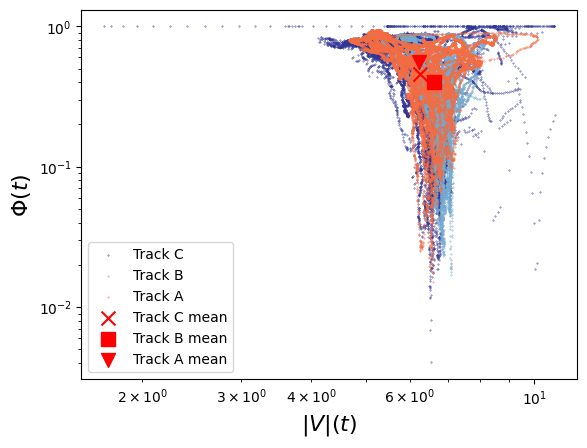

In [24]:
plt.scatter(df_C.groupby('time').V.mean(), vel_order_C, label='Track C', color=colors[4], s=0.1)
plt.scatter(df_B.groupby('time').V.mean(), vel_order_B, label='Track B', color=colors[3], s=0.1)
plt.scatter(df_A.groupby('time').V.mean(), vel_order_A, label='Track A', color=colors[0], s=0.1)
plt.scatter(np.mean(df_C.groupby('time').V.mean()), np.mean(vel_order_C), label='Track C mean', color='r', marker='x', s=100)
plt.scatter(np.mean(df_B.groupby('time').V.mean()), np.mean(vel_order_B), label='Track B mean', color='r', marker='s', s=100)
plt.scatter(np.mean(df_A.groupby('time').V.mean()), np.mean(vel_order_A), label='Track A mean', color='r', marker='v', s=100)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$|V|(t)$', fontsize=16)
plt.ylabel('$\Phi(t)$', fontsize=16)
plt.legend()
plt.savefig('velocity_order_parameter_vs_velocity_magnitude.png', dpi=300, bbox_inches='tight')

 95%|█████████▍| 4632/4881 [00:09<00:00, 532.97it/s]/Users/mmccraw/dev/yale/courses/integrated-workshop/project/code/data/utils.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  densities.append(sub_df.tid.nunique() / volume)
100%|██████████| 4881/4881 [00:09<00:00, 496.58it/s]


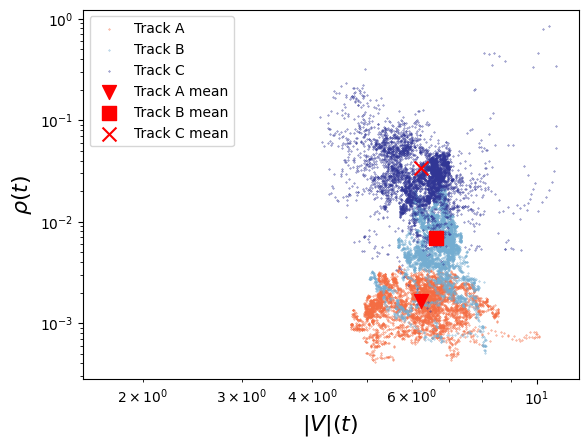

In [25]:
means = []
mags = []
for df, label, color in zip([df_A, df_B, df_C], ['Track A', 'Track B', 'Track C'], [colors[0], colors[3], colors[4]]):
    densities = get_number_densities(df)
    vel_mag = df.groupby('time').V.mean()
    vel_mag = downsample_A2B(vel_mag, densities[densities < 1e6])
    plt.scatter(vel_mag, densities[densities < 1e6], label=label, color=color, s=0.1)
    means.append(np.mean(densities[densities < 1e6]))
    mags.append(np.mean(vel_mag))
for df, label, mean, mag, marker in zip([df_A, df_B, df_C], ['Track A', 'Track B', 'Track C'], means, mags, ['v', 's', 'x']):
    plt.scatter(mag, mean, label=f'{label} mean', color='r', marker=marker, s=100)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$|V|(t)$', fontsize=16)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.legend()
plt.savefig('velocity_magnitude_vs_density.png', dpi=300, bbox_inches='tight')

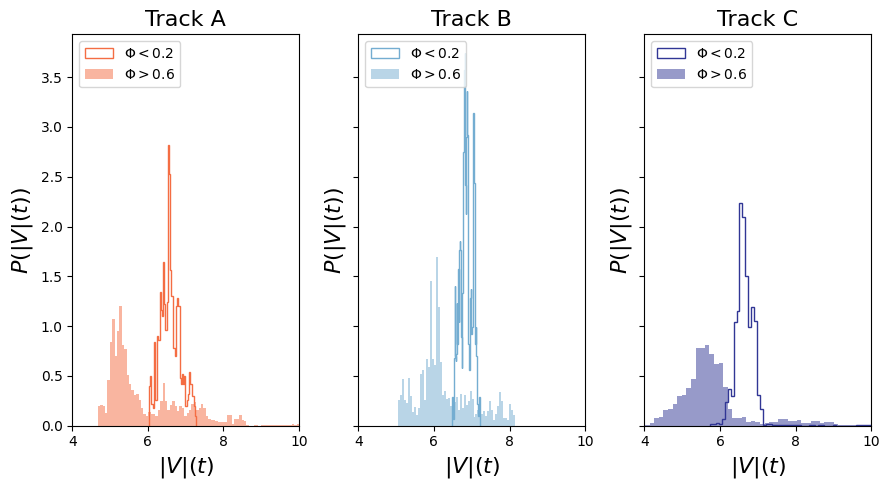

In [26]:
labels = ['Track A', 'Track B', 'Track C']
dfs = [df_A, df_B, df_C]
vel_orders = [vel_order_A, vel_order_B, vel_order_C]
cs = [colors[0], colors[3], colors[4]]

fig, ax = plt.subplots(1, 3, figsize=(9, 5), sharey=True, sharex=True)
ax[0].set_xlim(4, 10)
for i, (df, vel_order, label, color) in enumerate(zip(dfs, vel_orders, labels, cs)):
    for condition, cond_label in zip([vel_order > phi_high, vel_order < phi_low][::-1], [r'$\Phi>0.6$', r'$\Phi<0.2$'][::-1]):
        df_sub = df[df.time.isin(vel_order[condition].index.values)].copy()
        vel = vel_order[condition]
        vel_mag = df_sub.groupby('time').V.mean().values
        if vel.size > 0:
            if cond_label == r'$\Phi>0.6$':
                ax[i].hist(vel_mag, bins=int(np.sqrt(vel_mag.size)), color=color, density=True, label=cond_label, alpha=0.5)
            else:
                ax[i].hist(vel_mag, bins=int(np.sqrt(vel_mag.size)), color=color, density=True, histtype='step', label=cond_label)
    ax[i].legend(loc='upper left')
    ax[i].set_xlabel('$|V|(t)$', fontsize=16)
    ax[i].set_ylabel(r'$P(|V|(t))$', fontsize=16)
    ax[i].set_title(label, fontsize=16)
plt.tight_layout()
plt.savefig(f'high_vs_low_order_correlations_PDF_velocity_magnitude.png', dpi=300, bbox_inches='tight')

In [106]:
# TODO: neighbor distribution function

# (split the data into ordered and disordered REGIMES i.e. continuous time periods where the order parameter is above or below a certain threshold)

low_regimes_A, high_regimes_A = section_df_into_disordered_ordered_regimes(df_A)
low_A_all = pd.concat([df_A[df_A.time.isin(low)] for low in low_regimes_A])
high_A_all = pd.concat([df_A[df_A.time.isin(high)] for high in high_regimes_A])
low_A_bin, low_A_pdf = get_dist_pdf(low_A_all)
high_A_bin, high_A_pdf = get_dist_pdf(high_A_all)

low_regimes_B, high_regimes_B = section_df_into_disordered_ordered_regimes(df_B)
low_B_all = pd.concat([df_B[df_B.time.isin(low)] for low in low_regimes_B])
high_B_all = pd.concat([df_B[df_B.time.isin(high)] for high in high_regimes_B])
low_B_bin, low_B_pdf = get_dist_pdf(low_B_all)
high_B_bin, high_B_pdf = get_dist_pdf(high_B_all)

low_regimes_C, high_regimes_C = section_df_into_disordered_ordered_regimes(df_C)
low_C_all = pd.concat([df_C[df_C.time.isin(low)] for low in low_regimes_C])
high_C_all = pd.concat([df_C[df_C.time.isin(high)] for high in high_regimes_C])
low_C_bin, low_C_pdf = get_dist_pdf(low_C_all)
high_C_bin, high_C_pdf = get_dist_pdf(high_C_all)

100%|██████████| 5402/5402 [00:53<00:00, 101.64it/s]


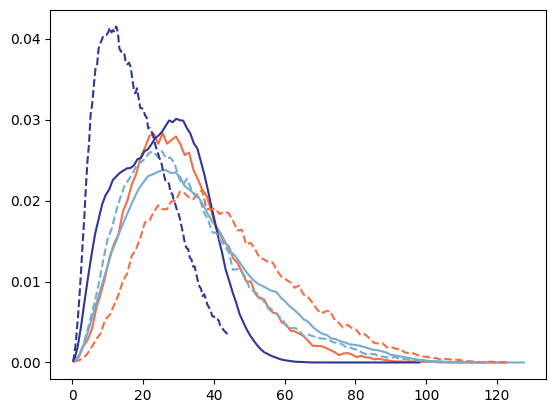

In [107]:
plt.plot(low_A_bin, low_A_pdf, label='Track A', color=colors[0])
plt.plot(low_B_bin, low_B_pdf, label='Track B', color=colors[3])
plt.plot(low_C_bin, low_C_pdf, label='Track C', color=colors[4])

plt.plot(high_A_bin, high_A_pdf, label='Track A', color=colors[0], linestyle='--')
plt.plot(high_B_bin, high_B_pdf, label='Track B', color=colors[3], linestyle='--')
plt.plot(high_C_bin, high_C_pdf, label='Track C', color=colors[4], linestyle='--')

In [108]:
order_all = pd.concat([high_A_all, high_B_all, high_C_all])
disorder_all = pd.concat([low_A_all, low_B_all, low_C_all])

density_order = get_number_densities(order_all)
density_disorder = get_number_densities(disorder_all)

variance_order = get_variance_ratios(order_all)
variance_disorder = get_variance_ratios(disorder_all)

vel_order = get_velocity_order_parameter(order_all)
vel_order = downsample_A2B(vel_order, density_order)

vel_disorder = get_velocity_order_parameter(disorder_all)
vel_disorder = downsample_A2B(vel_disorder, density_disorder)

100%|██████████| 2228/2228 [00:05<00:00, 388.23it/s]


In [130]:
order_bin, order_pdf = get_dist_pdf(order_all)
disorder_bin, disorder_pdf = get_dist_pdf(disorder_all)

100%|██████████| 6688/6688 [00:34<00:00, 191.40it/s]


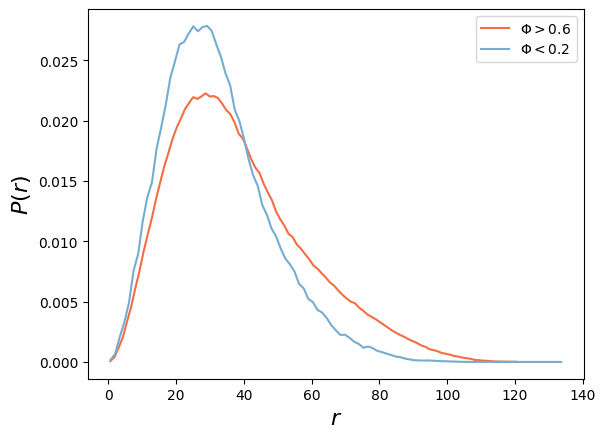

In [136]:
plt.plot(order_bin, order_pdf, label=r'$\Phi>0.6$', color=colors[0])
plt.plot(disorder_bin, disorder_pdf, label=r'$\Phi<0.2$', color=colors[3])
plt.legend()
plt.xlabel('$r$', fontsize=16)
plt.ylabel(r'$P(r)$', fontsize=16)
plt.savefig('order_vs_disorder_distance_PDF.png', dpi=300, bbox_inches='tight')

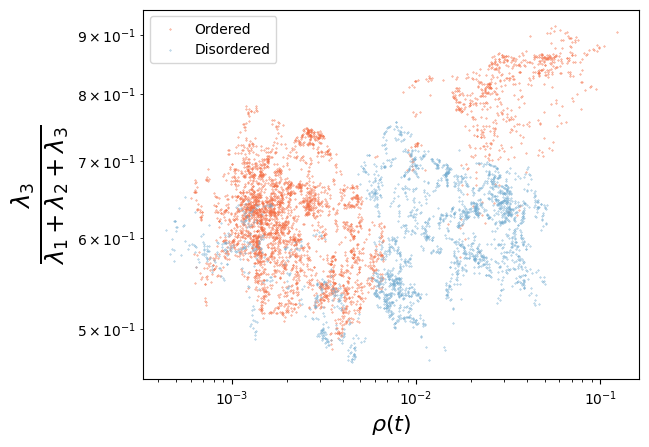

In [253]:
plt.scatter(density_order[density_order < 1e6], variance_order[:, 0][density_order < 1e6], label='Ordered', color=colors[0], s=0.1)
plt.scatter(density_disorder[density_disorder < 1e6], variance_disorder[:, 0][density_disorder < 1e6], label='Disordered', color=colors[3], s=0.1)
plt.legend()
plt.xlabel(r'$\rho(t)$', fontsize=16)
plt.ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.xscale('log')
plt.yscale('log')
plt.savefig('variance_ratios_vs_density_ordered_vs_disordered_with_first_dim.png', dpi=300, bbox_inches='tight')

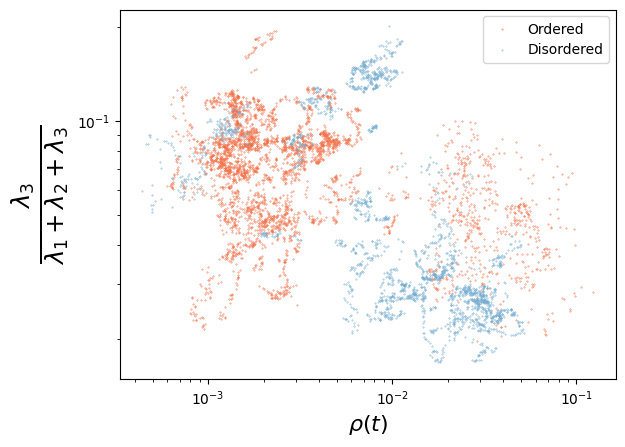

In [129]:
plt.scatter(density_order[density_order < 1e6], variance_order[:, 2][density_order < 1e6], label='Ordered', color=colors[0], s=0.1)
plt.scatter(density_disorder[density_disorder < 1e6], variance_disorder[:, 2][density_disorder < 1e6], label='Disordered', color=colors[3], s=0.1)
plt.legend()
plt.xlabel(r'$\rho(t)$', fontsize=16)
plt.ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.xscale('log')
plt.yscale('log')
plt.savefig('variance_ratios_vs_density_ordered_vs_disordered.png', dpi=300, bbox_inches='tight')

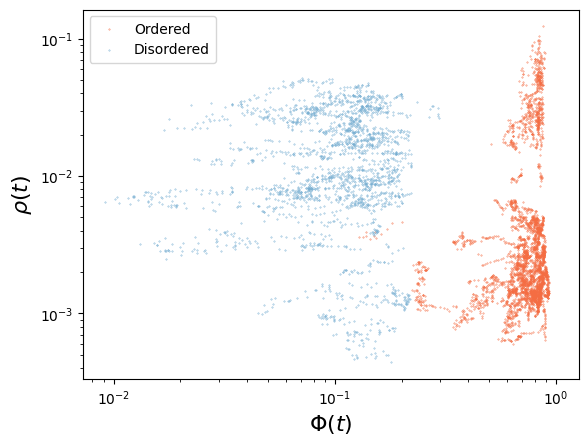

In [124]:
plt.scatter(vel_order[density_order < 1e6], density_order[density_order < 1e6], label='Ordered', color=colors[0], s=0.1)
plt.scatter(vel_disorder[density_disorder < 1e6], density_disorder[density_disorder < 1e6], label='Disordered', color=colors[3], s=0.1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\Phi(t)$', fontsize=16)
plt.ylabel(r'$\rho(t)$', fontsize=16)
plt.legend()

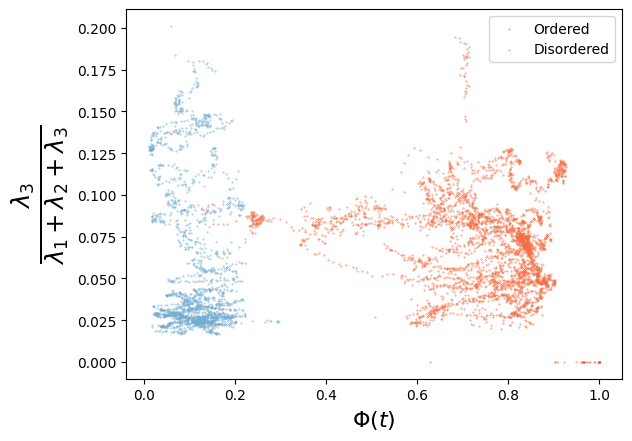

In [118]:
plt.scatter(vel_order, variance_order[:, 2], label='Ordered', color=colors[0], s=0.1)
plt.scatter(vel_disorder, variance_disorder[:, 2], label='Disordered', color=colors[3], s=0.1)
plt.legend()
plt.xlabel('$\Phi(t)$', fontsize=16)
plt.ylabel(r'$\frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3}$', fontsize=25)
plt.savefig('velocity_order_parameter_vs_variance_ratios_ordered_vs_disordered.png', dpi=300, bbox_inches='tight')

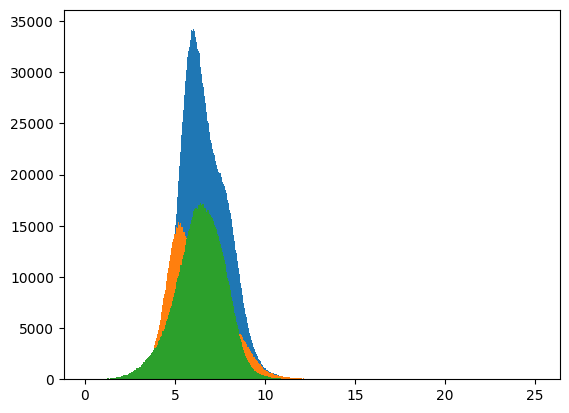

In [96]:
# TODO: comparison with maxwell boltzmann distribution

plt.hist(df_B.V, bins=int(np.sqrt(df_B.V.size)))
plt.hist(df_A.V, bins=int(np.sqrt(df_A.V.size)))
plt.hist(df_C.V, bins=int(np.sqrt(df_C.V.size)))
plt.show()

In [81]:
# better density calculation

dens_A_alt = get_number_densities_alt(df_A, skip_every_n_steps=3)
dens_B_alt = get_number_densities_alt(df_B, skip_every_n_steps=3)
dens_C_alt = get_number_densities_alt(df_C, skip_every_n_steps=3)

# these are very similar to the original density calculations, there is a slight underestimation of the density in the ordered regime, but it is systematic
# and thus shouldn't matter

In [139]:
# TODO: time correlation function of the principal component directions

principal_axes_A = get_principal_axes(df_A)
principal_axes_B = get_principal_axes(df_B)
principal_axes_C = get_principal_axes(df_C)

100%|██████████| 4881/4881 [00:09<00:00, 489.60it/s]


In [190]:
# plot the time correlation function of the principal axes for each track
A1 = time_correlation_function(principal_axes_A[:, 0])
A2 = time_correlation_function(principal_axes_A[:, 1])
A3 = time_correlation_function(principal_axes_A[:, 2])

B1 = time_correlation_function(principal_axes_B[:, 0])
B2 = time_correlation_function(principal_axes_B[:, 1])
B3 = time_correlation_function(principal_axes_B[:, 2])

C1 = time_correlation_function(principal_axes_C[:, 0])
C2 = time_correlation_function(principal_axes_C[:, 1])
C3 = time_correlation_function(principal_axes_C[:, 2])

100%|██████████| 4880/4880 [00:08<00:00, 598.11it/s] 


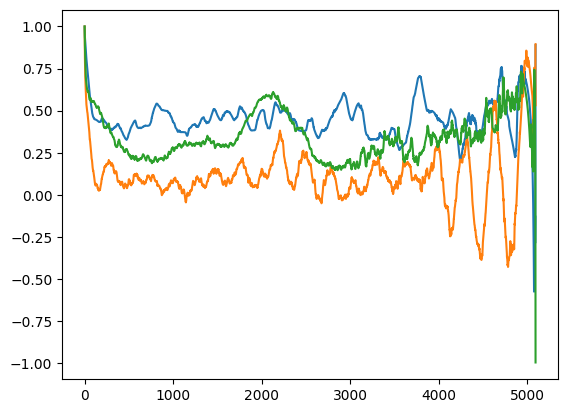

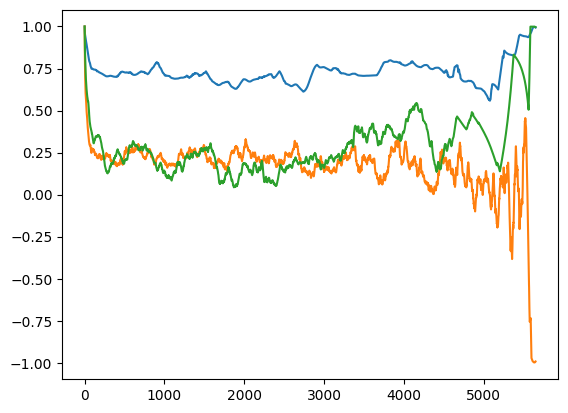

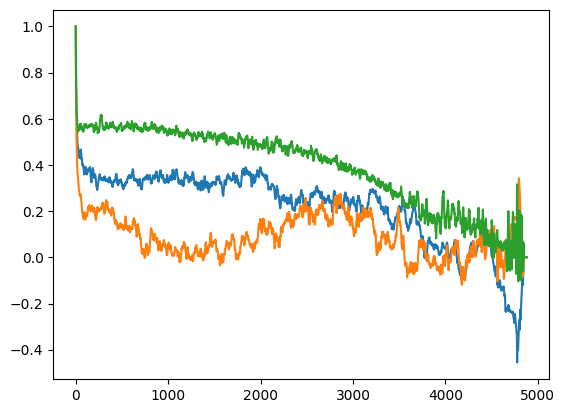

In [191]:
plt.plot(A1)
plt.plot(A2)
plt.plot(A3)
plt.show()

plt.plot(B1)
plt.plot(B2)
plt.plot(B3)
plt.show()

plt.plot(C1)
plt.plot(C2)
plt.plot(C3)
plt.show()

100%|██████████| 46/46 [00:00<00:00, 21366.33it/s]


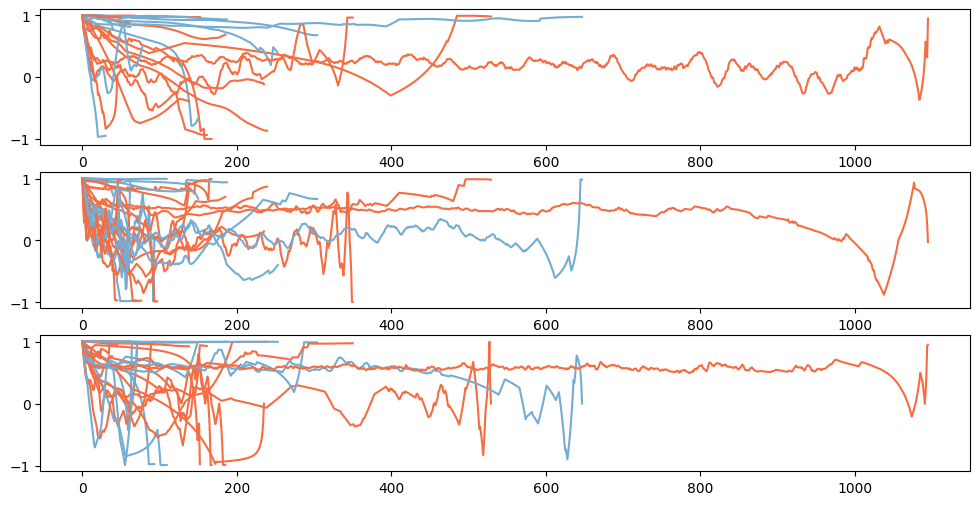

In [192]:
# get the time correlation function of the principal axes for each ordered / disordered segment

disordered_principal_axes = []
ordered_principal_axes = []

disordered_pca_corr_1 = []
ordered_pca_corr_1 = []
disordered_pca_corr_2 = []
ordered_pca_corr_2 = []
disordered_pca_corr_3 = []
ordered_pca_corr_3 = []

fig, axs = plt.subplots(3, 1, figsize=(12, 6))
for df, low_regimes, high_regimes in zip([df_A, df_B, df_C], [low_regimes_A, low_regimes_B, low_regimes_C], [high_regimes_A, high_regimes_B, high_regimes_C]):
    for low, high in zip(low_regimes, high_regimes):
        disordered_principal_axes.append(get_principal_axes(df[df.time.isin(low)]))
        ordered_principal_axes.append(get_principal_axes(df[df.time.isin(high)]))

        disordered_pca_corr_1.append(time_correlation_function(disordered_principal_axes[-1][:, 0]))
        ordered_pca_corr_1.append(time_correlation_function(ordered_principal_axes[-1][:, 0]))
        disordered_pca_corr_2.append(time_correlation_function(disordered_principal_axes[-1][:, 1]))
        ordered_pca_corr_2.append(time_correlation_function(ordered_principal_axes[-1][:, 1]))
        disordered_pca_corr_3.append(time_correlation_function(disordered_principal_axes[-1][:, 2]))
        ordered_pca_corr_3.append(time_correlation_function(ordered_principal_axes[-1][:, 2]))

        axs[0].plot(disordered_pca_corr_1[-1], color=colors[3])
        axs[0].plot(ordered_pca_corr_1[-1], color=colors[0])
        axs[1].plot(disordered_pca_corr_2[-1], color=colors[3])
        axs[1].plot(ordered_pca_corr_2[-1], color=colors[0])
        axs[2].plot(disordered_pca_corr_3[-1], color=colors[3])
        axs[2].plot(ordered_pca_corr_3[-1], color=colors[0])


In [276]:
combined_df = pd.concat([df_A, df_B, df_C])

vel_order_all = get_velocity_order_parameter(combined_df)
ordered = combined_df[combined_df.time.isin(vel_order_all[vel_order_all > 0.7].index.values)]
disordered = combined_df[combined_df.time.isin(vel_order_all[vel_order_all < 0.3].index.values)]


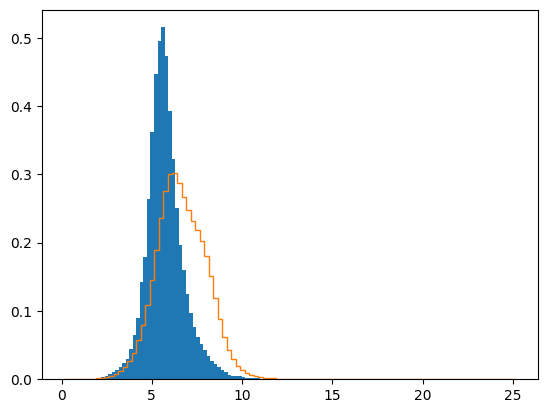

In [277]:
plt.hist(ordered.V, bins=100, density=True)
plt.hist(disordered.V, bins=100, density=True, histtype='step')
plt.show()

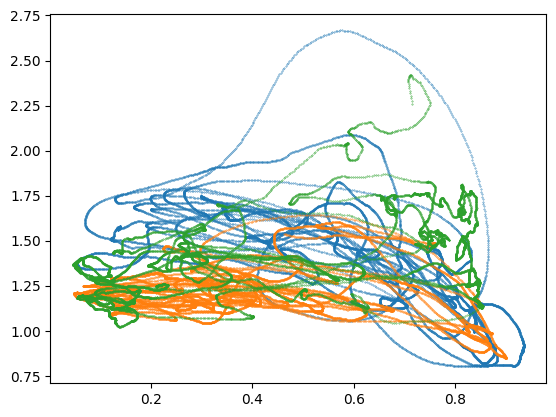

In [306]:
# plt.scatter(df_A.groupby('time').V.std(), vel_order_A, s=0.1)
# plt.scatter(df_B.groupby('time').V.std(), vel_order_B, s=0.1)
# plt.scatter(df_C.groupby('time').V.std(), vel_order_C, s=0.1)
vel_mag_order_A = df_A.groupby('time').V.std()
vel_mag_order_B = df_B.groupby('time').V.std()
vel_mag_order_C = df_C.groupby('time').V.std()

win_size = int(df_A.time.nunique() * 0.01) + 1
plt.scatter(np_convolve_moving_average(vel_order_A, win_size), np_convolve_moving_average(vel_mag_order_A, win_size), s=0.1)
plt.scatter(np_convolve_moving_average(vel_order_B, win_size), np_convolve_moving_average(vel_mag_order_B, win_size), s=0.1)
plt.scatter(np_convolve_moving_average(vel_order_C, win_size), np_convolve_moving_average(vel_mag_order_C, win_size), s=0.1)

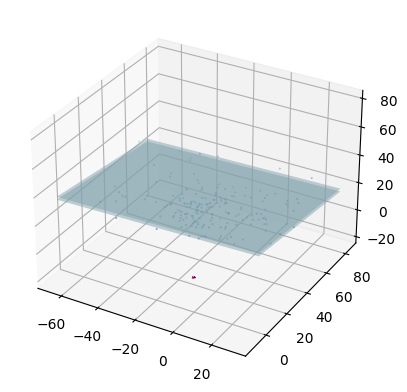

time
71.738405    0.353282
dtype: float64

In [238]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming df_A is already defined and it has columns 'x', 'y', 'z', and 'time'

df = df_A.copy()

sdf = df[df.time == np.sort(df.time.unique())[1400]]

pca = PCA(n_components=3)
pca.fit(sdf[['x', 'y', 'z']])
v1 = pca.components_[0]  # First PCA axis
v2 = pca.components_[1]  # Second PCA axis
v3 = pca.components_[2]  # Third PCA axis (for offset)

normal = np.cross(v1, v2)
point = np.mean(sdf[['x', 'y', 'z']].values, axis=0)
d = -point.dot(normal)

xx, yy = np.meshgrid(np.linspace(min(sdf.x), max(sdf.x), 10), np.linspace(min(sdf.y), max(sdf.y), 10))
zz = (-normal[0] * xx - normal[1] * yy - d) / normal[2]

# Calculate offset for the third PCA axis
offset = np.linalg.norm(v3)

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

# Plot the planes (one above and one below the swarm)
ax.plot_surface(xx, yy, zz + offset, alpha=0.5, rstride=100, cstride=100, color='lightblue')
ax.plot_surface(xx, yy, zz - offset, alpha=0.5, rstride=100, cstride=100, color='lightblue')

# Highlight the original vectors
ax.quiver(0, 0, 0, v1[0], v1[1], v1[2], color='r')
ax.quiver(0, 0, 0, v2[0], v2[1], v2[2], color='b')

# Plot the swarm
ax.scatter(sdf.x, sdf.y, sdf.z, s=0.1)

# Set axes to be equal
max_range = np.array([sdf.x.max() - sdf.x.min(), sdf.y.max() - sdf.y.min(), sdf.z.max() - sdf.z.min()]).max() / 2.0
mid_x = (sdf.x.max() + sdf.x.min()) * 0.5
mid_y = (sdf.y.max() + sdf.y.min()) * 0.5
mid_z = (sdf.z.max() + sdf.z.min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()
order_parameter = get_velocity_order_parameter(sdf)
order_parameter

[0.80703161]


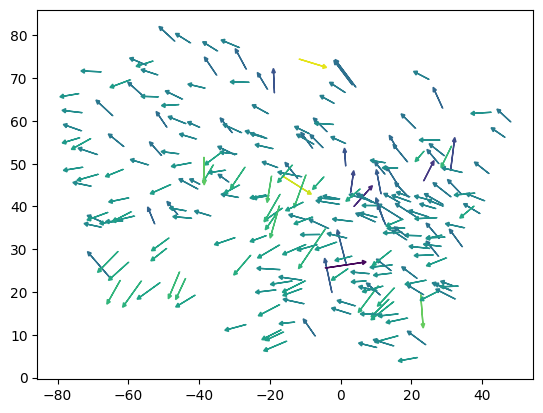

In [360]:

# plot vectors from x, y in the direction of vx, vy at fixed time
norm = plt.Normalize(vmin=df_A.hdg.min(), vmax=df_A.hdg.max())
index = 110
print(vel_order_A[vel_order_A.index == np.sort(df_A.time.unique())[index]].values)
sdf = df_A[df_A.time == np.sort(df_A.time.unique())[index]]
fig, ax = plt.subplots()
cmap = plt.cm.viridis
for x, y, vx, vy, hdg in zip(sdf.x.values, sdf.y.values, sdf.vx.values, sdf.vy.values, sdf.hdg.values):
    color = cmap(norm(hdg))
    ax.arrow(x, y, vx, vy, head_width=1, head_length=1, color=color)

MovieWriter imagemagick unavailable; using Pillow instead.


Frame 0 of 15296
Frame 102 of 15296
Frame 205 of 15296
Frame 307 of 15296
Frame 410 of 15296
Frame 513 of 15296
Frame 615 of 15296
Frame 718 of 15296
Frame 821 of 15296
Frame 923 of 15296
Frame 1026 of 15296
Frame 1129 of 15296
Frame 1231 of 15296
Frame 1334 of 15296
Frame 1437 of 15296
Frame 1539 of 15296
Frame 1642 of 15296
Frame 1745 of 15296
Frame 1847 of 15296
Frame 1950 of 15296
Frame 2053 of 15296
Frame 2155 of 15296
Frame 2258 of 15296
Frame 2360 of 15296
Frame 2463 of 15296
Frame 2566 of 15296
Frame 2668 of 15296
Frame 2771 of 15296
Frame 2874 of 15296
Frame 2976 of 15296
Frame 3079 of 15296
Frame 3182 of 15296
Frame 3284 of 15296
Frame 3387 of 15296
Frame 3490 of 15296
Frame 3592 of 15296
Frame 3695 of 15296
Frame 3798 of 15296
Frame 3900 of 15296
Frame 4003 of 15296
Frame 4106 of 15296
Frame 4208 of 15296
Frame 4311 of 15296
Frame 4413 of 15296
Frame 4516 of 15296
Frame 4619 of 15296
Frame 4721 of 15296
Frame 4824 of 15296
Frame 4927 of 15296
Frame 5029 of 15296
Frame 5132 o

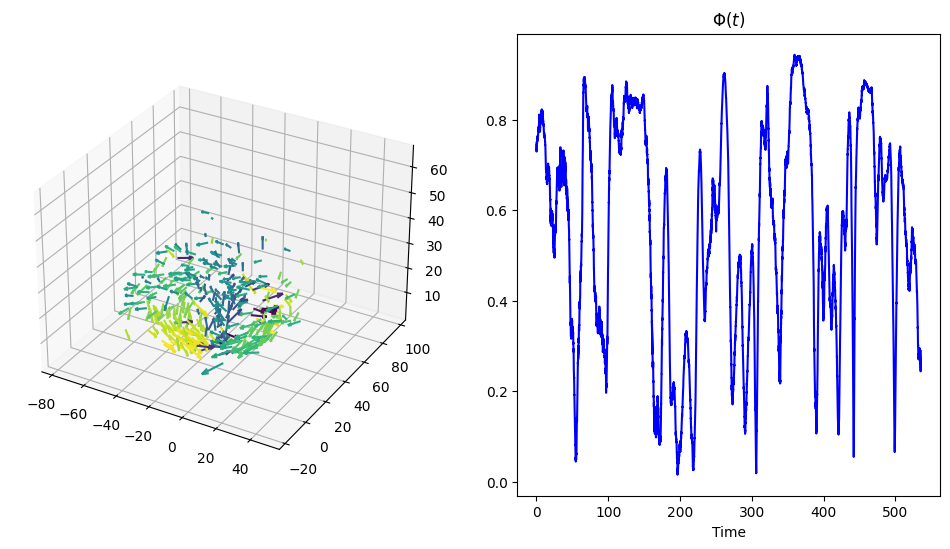

MovieWriter imagemagick unavailable; using Pillow instead.


Frame 0 of 16961
Frame 100 of 16961
Frame 200 of 16961
Frame 301 of 16961
Frame 401 of 16961
Frame 501 of 16961
Frame 602 of 16961
Frame 702 of 16961
Frame 802 of 16961
Frame 903 of 16961
Frame 1003 of 16961
Frame 1103 of 16961
Frame 1204 of 16961
Frame 1304 of 16961
Frame 1404 of 16961
Frame 1505 of 16961
Frame 1605 of 16961
Frame 1706 of 16961
Frame 1806 of 16961
Frame 1906 of 16961
Frame 2007 of 16961
Frame 2107 of 16961
Frame 2207 of 16961
Frame 2308 of 16961
Frame 2408 of 16961
Frame 2508 of 16961
Frame 2609 of 16961
Frame 2709 of 16961
Frame 2809 of 16961
Frame 2910 of 16961
Frame 3010 of 16961
Frame 3111 of 16961
Frame 3211 of 16961
Frame 3311 of 16961
Frame 3412 of 16961
Frame 3512 of 16961
Frame 3612 of 16961
Frame 3713 of 16961
Frame 3813 of 16961
Frame 3913 of 16961
Frame 4014 of 16961
Frame 4114 of 16961
Frame 4214 of 16961
Frame 4315 of 16961
Frame 4415 of 16961
Frame 4515 of 16961
Frame 4616 of 16961
Frame 4716 of 16961
Frame 4817 of 16961
Frame 4917 of 16961
Frame 5017 o

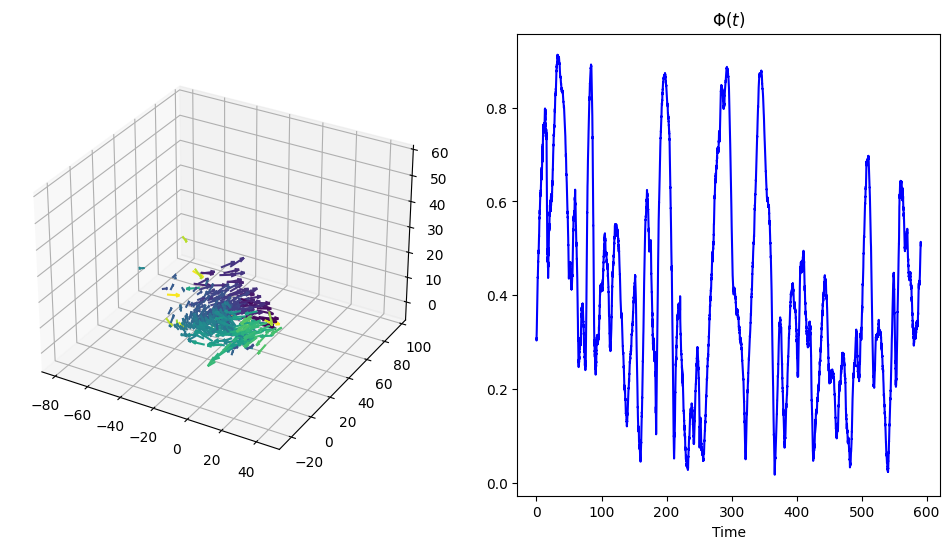

MovieWriter imagemagick unavailable; using Pillow instead.


Frame 0 of 14647
Frame 92 of 14647
Frame 184 of 14647
Frame 276 of 14647
Frame 368 of 14647
Frame 460 of 14647
Frame 552 of 14647
Frame 644 of 14647
Frame 736 of 14647
Frame 829 of 14647
Frame 921 of 14647
Frame 1013 of 14647
Frame 1105 of 14647
Frame 1197 of 14647
Frame 1289 of 14647
Frame 1381 of 14647
Frame 1473 of 14647
Frame 1565 of 14647
Frame 1658 of 14647
Frame 1750 of 14647
Frame 1842 of 14647
Frame 1934 of 14647
Frame 2026 of 14647
Frame 2118 of 14647
Frame 2210 of 14647
Frame 2302 of 14647
Frame 2394 of 14647
Frame 2487 of 14647
Frame 2579 of 14647
Frame 2671 of 14647
Frame 2763 of 14647
Frame 2855 of 14647
Frame 2947 of 14647
Frame 3039 of 14647
Frame 3131 of 14647
Frame 3223 of 14647
Frame 3316 of 14647
Frame 3408 of 14647
Frame 3500 of 14647
Frame 3592 of 14647
Frame 3684 of 14647
Frame 3776 of 14647
Frame 3868 of 14647
Frame 3960 of 14647
Frame 4052 of 14647
Frame 4145 of 14647
Frame 4237 of 14647
Frame 4329 of 14647
Frame 4421 of 14647
Frame 4513 of 14647
Frame 4605 of 

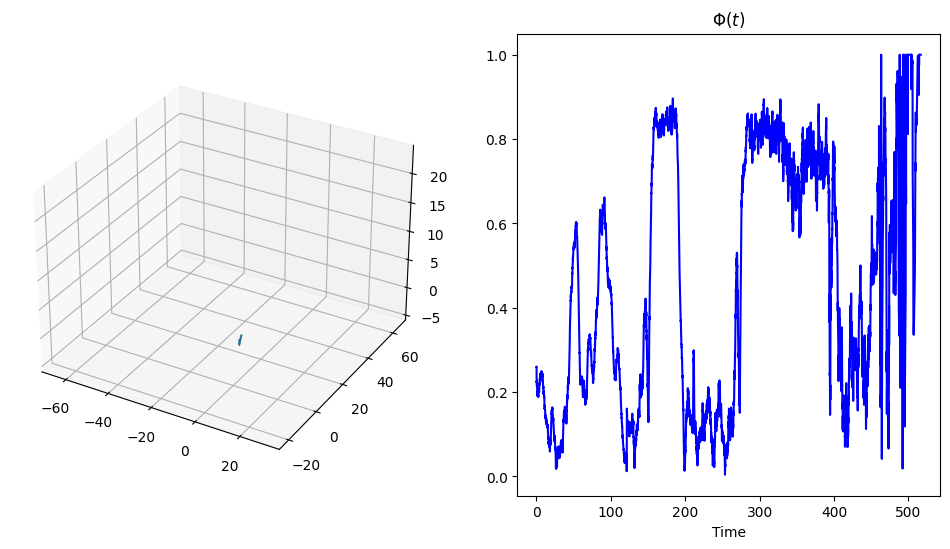

In [365]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def animate(df, N_frames, name):
    vel_order = get_velocity_order_parameter(df)
    norm = plt.Normalize(vmin=df.hdg.min(), vmax=df.hdg.max())
    cmap = plt.cm.viridis

    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    times = np.sort(df.time.unique())

    # Initialize the 3D plot
    def init_3d_plot():
        ax1.clear()
        ax1.set_xlim(df.x.min(), df.x.max())
        ax1.set_ylim(df.y.min(), df.y.max())
        ax1.set_zlim(df.z.min(), df.z.max())

    # Update function for the animation
    def update(frame):
        # Update the 3D plot
        init_3d_plot()
        sdf = df[df.time == times[frame]]
        for x, y, z, vx, vy, vz, hdg in zip(sdf.x, sdf.y, sdf.z, sdf.vx, sdf.vy, sdf.vz, sdf.hdg):
            color = cmap(norm(hdg))
            ax1.quiver(x, y, z, vx, vy, vz, color=color)

        # Update the historical plot
        ax2.clear()
        ax2.plot(np.linspace(0, times[frame], vel_order[vel_order.index <= times[frame]].size), vel_order[vel_order.index <= times[frame]], color='blue')
        ax2.set_title(r"$\Phi(t)$")
        ax2.set_xlabel("Time")
        print(f"Frame {frame} of {len(times)}")


    # Calculate indices of evenly spaced frames
    frames_to_use = np.linspace(0, len(times) - 1, N_frames, dtype=int)

    # Creating the animation
    ani = FuncAnimation(fig, update, frames=frames_to_use, init_func=init_3d_plot, repeat=False)
    ani.save(name, writer='imagemagick', fps=10)

    plt.show()

animate(df_A, 150, 'anim_track_A.gif')
animate(df_B, 170, 'anim_track_B.gif')
animate(df_C, 160, 'anim_track_C.gif')


In [383]:
# measure the milling alignment function
df = df_A.copy()

ma = []
times = np.sort(df.time.unique())

for time in tqdm(times):
    # Filter the DataFrame only once per time
    df_time = df[df.time == time]

    # Compute the center of mass (r_cm) once for all particles at this time
    r_cm = df_time[['x', 'y', 'z']].mean().values

    # Calculate rcm for all particles at once
    rcm = df_time[['x', 'y', 'z']].values - r_cm

    # Get velocities for all particles
    v = df_time[['vx', 'vy', 'vz']].values

    # Vectorized cross product and norms
    cross_product_norms = np.linalg.norm(np.cross(rcm, v, axis=1), axis=1)
    rcm_norms = np.linalg.norm(rcm, axis=1)
    v_norms = np.linalg.norm(v, axis=1)

    # Calculate the values and append their mean
    vals = cross_product_norms / rcm_norms / v_norms
    ma.append(np.mean(vals))

100%|██████████| 15296/15296 [00:32<00:00, 466.74it/s]


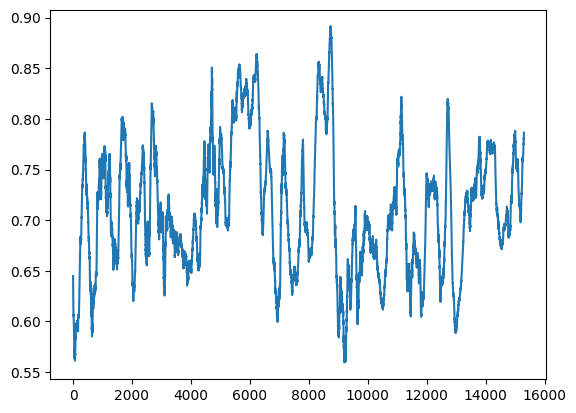

In [384]:
plt.plot(ma)

In [206]:
# TODO: velocity autocorrelation function (will probably need the function below for filtering out non-persistent birds)

In [ ]:
# TODO: use the function below to filter the data to only include the persistent birds
df = get_birds_in_time_range(df_A, time_start=40, time_end=42.5)